In [1]:
pip install torch torchvision


In [2]:
pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import timm
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [4]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Set CUDA_LAUNCH_BLOCKING environment variable
!export CUDA_LAUNCH_BLOCKING=1


In [6]:
# Set your custom dataset path
data_dir = "gdrive/MyDrive/Colab Notebooks/ucb_capstone_asd_detection/data_rev1"

In [7]:
# Set the number of classes in your dataset
num_classes = 4

# Set batch size, number of epochs, and learning rate
batch_size = 20
num_epochs = 25
learning_rate = 1e-4

In [8]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/train', transforms.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

(tensor([0.0013, 0.0014, 0.0011]), tensor([0.0100, 0.0114, 0.0106]))

In [9]:
# Data transformations

In [10]:
stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(*stats,inplace=True)
                                    ])

In [11]:
# Load your custom dataset
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

In [12]:
# Split the dataset into train and validation sets
train_size = int(0.7 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


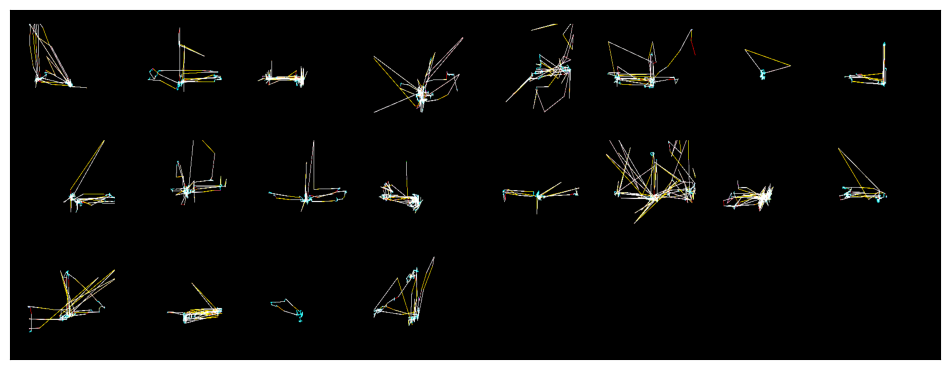

In [15]:
show_batch(train_loader);

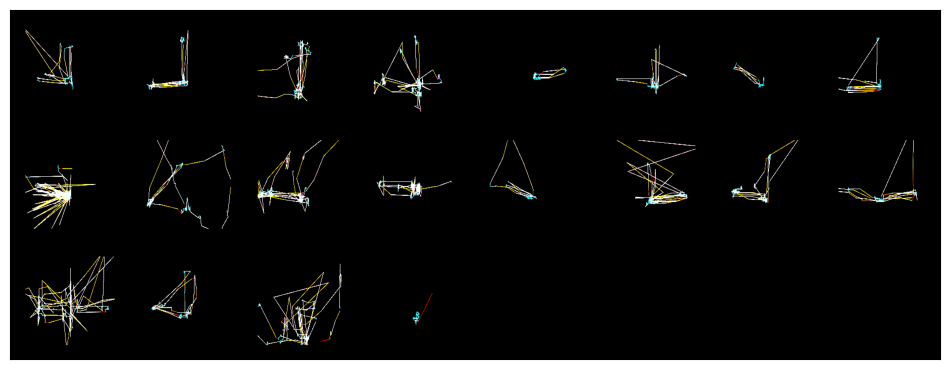

In [16]:
show_batch(val_loader);

In [17]:
# Load a pre-trained ViT model (e.g., ViT-B/16)
model = timm.create_model("vit_base_patch16_224", pretrained=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [18]:
# Modify the final classification head for your specific number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Transfer the model to a GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [21]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.7f}, Validation Loss: {val_loss:.7f}, Validation Accuracy: {100 * correct / total:.4f}%")

Epoch 1/25, Train Loss: 0.5843645, Validation Loss: 1.0279619, Validation Accuracy: 92.7273%
Epoch 2/25, Train Loss: 0.4786511, Validation Loss: 0.9937030, Validation Accuracy: 92.7273%
Epoch 3/25, Train Loss: 0.3647116, Validation Loss: 0.1489565, Validation Accuracy: 92.7273%
Epoch 4/25, Train Loss: 0.3513516, Validation Loss: 0.1777732, Validation Accuracy: 92.7273%
Epoch 5/25, Train Loss: 0.3563909, Validation Loss: 1.1530805, Validation Accuracy: 92.7273%
Epoch 6/25, Train Loss: 0.3279561, Validation Loss: 0.0535993, Validation Accuracy: 92.7273%
Epoch 7/25, Train Loss: 0.1938669, Validation Loss: 0.0310589, Validation Accuracy: 80.6061%
Epoch 8/25, Train Loss: 0.1410220, Validation Loss: 0.0052547, Validation Accuracy: 87.2727%
Epoch 9/25, Train Loss: 0.0538519, Validation Loss: 0.0079000, Validation Accuracy: 92.1212%
Epoch 10/25, Train Loss: 0.0343017, Validation Loss: 0.0000292, Validation Accuracy: 90.9091%
Epoch 11/25, Train Loss: 0.0220943, Validation Loss: 0.0000001, Valid

In [ ]:
# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_vit.pth')

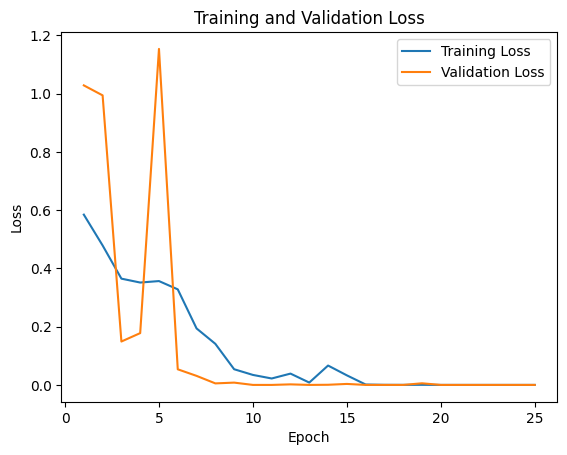

In [22]:
# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()